In [1]:
%load_ext autoreload
%autoreload 2

In [2]:
import torchvision

from rae.modules.enumerations import Output
from rae.pl_modules.pl_gautoencoder import LightningAutoencoder
from rae.utils.evaluation import parse_checkpoints_tree, parse_checkpoint

try:
    # be ready for 3.10 when it drops
    from enum import StrEnum
except ImportError:
    from backports.strenum import StrEnum
from rae.utils.evaluation import get_dataset
import matplotlib.pyplot as plt
from tueplots import bundles
from tueplots import figsizes
import logging
from typing import Optional

import numpy as np
import torch
from sklearn.utils import shuffle

from nn_core.common import PROJECT_ROOT

logging.getLogger().setLevel(logging.ERROR)


BATCH_SIZE = 256


EXPERIMENT_ROOT = PROJECT_ROOT / "experiments" / "sec:model-reusability-ae"
EXPERIMENT_CHECKPOINTS = EXPERIMENT_ROOT / "checkpoints"

checkpoints, RUNS = parse_checkpoints_tree(EXPERIMENT_CHECKPOINTS)

/home/luca/Repos/rae/src/rae/data/vision/datamodule.py:406: UserWarning: 
The version_base parameter is not specified.
Please specify a compatability version level, or None.
Will assume defaults for version 1.1
  @hydra.main(config_path=str(PROJECT_ROOT / "conf"), config_name="default")


In [3]:
def plot_images(ax, images: torch.Tensor, title: Optional[str] = None, images_per_row=10, padding=2, resize=None):
    if resize is not None:
        images = resize(images)
    images = images.cpu().detach()
    ax.imshow(torchvision.utils.make_grid(images.cpu(), images_per_row, padding=padding, pad_value=1).permute(1, 2, 0))

# Dataset

In [4]:
%%capture

PL_MODULE = LightningAutoencoder

num_samples = 20

mnist = get_dataset(pl_module=PL_MODULE, ckpt=checkpoints["mnist"]["ae"][0])
fmnist = get_dataset(pl_module=PL_MODULE, ckpt=checkpoints["fmnist"]["ae"][0])
cifar10 = get_dataset(pl_module=PL_MODULE, ckpt=checkpoints["cifar10"]["ae"][0])

In [5]:
from pprint import pprint
from pytorch_lightning import seed_everything

seed_everything(0)


def get_class2idx(dataset, k: int = 10):
    shuffled_idxs, shuffled_targets = shuffle(
        np.asarray(list(range(len(dataset)))),
        np.asarray(dataset.targets),
        random_state=0,
    )
    all_targets = sorted(set(shuffled_targets))
    class2idxs = {target: shuffled_idxs[shuffled_targets == target][:k] for target in all_targets}
    return class2idxs


mnist_class2idx = get_class2idx(mnist)
fmnist_class2idx = get_class2idx(fmnist)
cifar10_class2idx = get_class2idx(cifar10)

2022-09-26 21:23:38 INFO     Global seed set to 0                               ]8;id=267345;file:///home/luca/miniconda3/envs/rae/lib/python3.8/site-packages/pytorch_lightning/utilities/seed.py\pytorch_lightning.utilities.seed]8;;\:]8;id=175862;file:///home/luca/miniconda3/envs/rae/lib/python3.8/site-packages/pytorch_lightning/utilities/seed.py#69\69]8;;\


# Sample selection

In [6]:
mnist_class2idx

{
    0: array([3724, 6526, 7913, 4857, 6798, 2821, 2932,  713, 3646, 3706]),
    1: array([2398, 2343, 5506, 6652, 5013, 6419, 6058, 4185, 5350, 4595]),
    2: array([8225, 6084, 9547, 9477, 9032, 5615, 3986, 4387,  467, 8830]),
    3: array([2308,  382, 9491, 8451,  982, 5814, 7407, 5892, 4808, 8876]),
    4: array([3497, 3728, 7883, 3017, 4721, 4974, 6734, 6332, 2375, 4379]),
    5: array([2670, 1087, 2930, 8089, 8711, 2606, 8940, 5957, 4302, 5608]),
    6: array([1819, 6387, 2702, 9366, 4346, 1478, 2846, 3725, 6846, 8148]),
    7: array([ 898, 5906, 3184, 5988, 3213, 4747, 5334, 8480, 5313, 9300]),
    8: array([9394, 4890, 5423,  580, 5611, 6625, 4429, 3951,  655, 8894]),
    9: array([6451, 6718, 4237, 4795, 5602, 1559, 7813,  598, 3891, 4644])
}

In [7]:
fmnist_class2idx

{
    0: array([2308, 7883, 4795, 5334, 8885, 3986, 8089, 5350, 4228, 6846]),
    1: array([2930, 4974,  843, 2606, 6450, 3891, 5892, 4678, 1308,  296]),
    2: array([3017,  382, 6625, 6734, 9300, 2932, 4379, 4221, 8314,  841]),
    3: array([1087, 6526, 5611, 5615, 6332, 6798,  713, 3646, 3706, 4808]),
    4: array([2398, 8225, 6387, 9547, 9477, 9366, 8480, 2375, 1312, 3683]),
    5: array([ 898, 5906, 1819, 6718, 5423, 4721, 4747, 6652, 4857, 2821]),
    6: array([2670, 3497, 3724, 4237, 9032, 1559, 4429, 3951,  655, 1096]),
    7: array([9394, 5506, 5988,  580, 8451, 5313, 7813, 8894, 3066, 5608]),
    8: array([2343, 6084, 3213, 9491, 7913, 5602, 6058, 7219,  982, 7439]),
    9: array([6451, 3184, 3728, 2702, 4890, 4346, 1478, 8711, 1422, 2846])
}

In [8]:
cifar10_class2idx

{
    0: array([3497, 1819, 3184,  382, 2821, 2375, 5013,  982, 8894, 4387]),
    1: array([6451, 2308, 6084, 4890, 4237, 4721, 3951, 6058, 4379, 3891]),
    2: array([6387, 3728, 9366, 6652, 8480, 4429,  843,  655, 4221, 3725]),
    3: array([ 898, 5506, 4346, 5313, 8885, 7813, 3646, 2606,  467, 4808]),
    4: array([5906, 9547,  580, 6625, 5602, 8711, 3706, 5957, 2869, 1534]),
    5: array([9394, 3017, 9477, 4795, 4747, 5611, 5615, 8451, 6332, 9300]),
    6: array([2343, 1087, 3724, 2702, 5423, 5334, 4857, 8940, 2846, 8314]),
    7: array([2930, 4974, 1478, 3986,  713, 4185, 7219, 1096, 5301, 9672]),
    8: array([2398, 6718, 9491, 6526, 7913, 6734, 6798, 1422, 5814, 5892]),
    9: array([8225, 2670, 7883, 5988, 3213, 9032, 2932, 6419, 8089, 5350])
}

In [9]:
[mnist_class2idx[x][0] for x in mnist_class2idx]

[3724, 2398, 8225, 2308, 3497, 2670, 1819, 898, 9394, 6451]

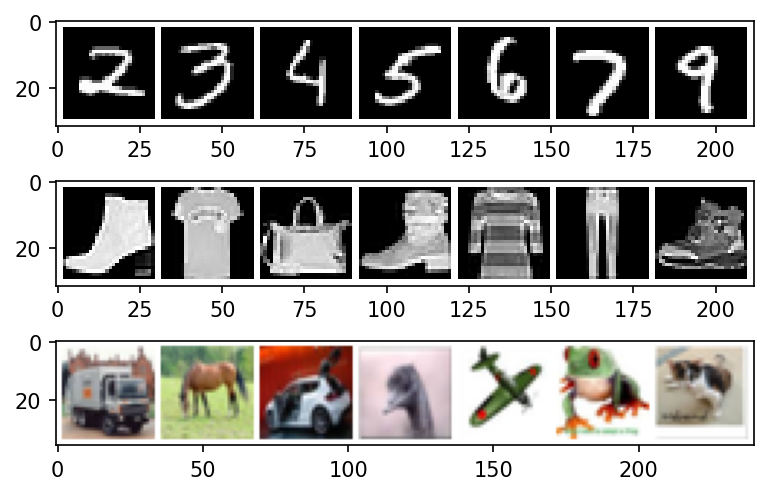

In [10]:
from torch.utils.data import default_collate

mnist_idxs = [8225, 7407, 4721, 8940, 2846, 5334, 598]  # [mnist_class2idx[x][6] for x in mnist_class2idx]
fmnist_idxs = [ 8711, 19,  6058, 2702,  382, 3891, 122]  # [fmnist_class2idx[x][1] for x in mnist_class2idx]
cifar10_idxs = [11, 60, 6, 84, 98, 8940, 2606]  # + [cifar10_class2idx[x][7] for x in mnist_class2idx]

batch_mnist = default_collate([mnist[i] for i in mnist_idxs])
batch_fmnist = default_collate([fmnist[i] for i in fmnist_idxs])
batch_cifar10 = default_collate([cifar10[i] for i in cifar10_idxs])


fig, [ax1, ax2, ax3] = plt.subplots(
    3,
    1,
    dpi=150,
)
plot_images(
    ax1,
    batch_mnist["image"],
)
plot_images(
    ax2,
    batch_fmnist["image"],
)
plot_images(
    ax3,
    batch_cifar10["image"],
)

plot_images(ax1, batch_mnist['image'], )
# Visualize

In [11]:
from rae.pl_modules.pl_stitching_module import StitchingModule
from torchvision.transforms import Resize

resize = Resize((28, 28))


def plot_images(ax, images: torch.Tensor, title: Optional[str] = None, images_per_row=10, padding=2, resize=None):
    ax.axis("off")
    ax.set_aspect("equal")

    if resize is not None:
        images = resize(images)
    images = images.cpu().detach()
    ax.imshow(torchvision.utils.make_grid(images.cpu(), images_per_row, padding=padding, pad_value=1).permute(1, 2, 0))


def plot_stitching(ax, ckpt_a, ckpt_b, images, padding=2, resize=resize):
    model_a, _ = parse_checkpoint(
        module_class=PL_MODULE,
        checkpoint_path=ckpt_a,
        map_location="cpu",
    )

    model_b, _ = parse_checkpoint(
        module_class=PL_MODULE,
        checkpoint_path=ckpt_b,
        map_location="cpu",
    )
    recon_a = model_a(images)[Output.RECONSTRUCTION]
    model_ab = StitchingModule(model_a, model_b)
    recon_ab = model_ab(images)[Output.RECONSTRUCTION]

    plot_images(ax, torch.cat([recon_a, recon_ab]), images_per_row=recon_a.shape[0], padding=padding, resize=resize)

/tmp/ipykernel_50164/991598363.py:17: UserWarning: This figure was using constrained_layout, but that is incompatible with subplots_adjust and/or tight_layout; disabling constrained_layout.
  fig.subplots_adjust(hspace=0.02, wspace=0.01)


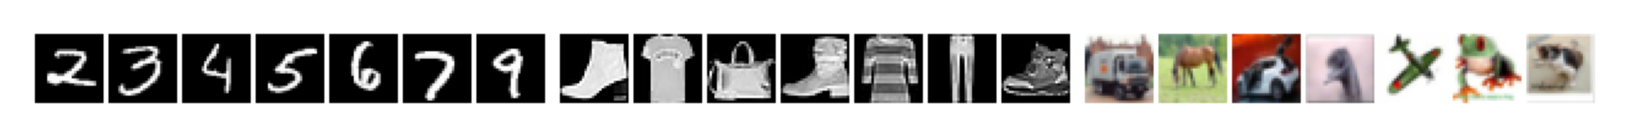

In [12]:
N_ROWS = 1
N_COLS = 3
RATIO = 0.3

plt.rcParams.update(bundles.icml2022())
plt.rcParams.update(figsizes.icml2022_full(ncols=N_COLS, nrows=N_ROWS, height_to_width_ratio=RATIO))


fig, [source_mnist_ax, source_fmnist_ax, source_cifar10_ax] = plt.subplots(
    N_ROWS,
    N_COLS,
    dpi=300,
    sharey=True,
    sharex=True,
    # constrained_layout=True
)
fig.subplots_adjust(hspace=0.02, wspace=0.01)


plot_images(source_mnist_ax, batch_mnist["image"], resize=resize)
plot_images(source_fmnist_ax, batch_fmnist["image"], resize=resize)
plot_images(source_cifar10_ax, batch_cifar10["image"], resize=resize)

In [13]:
fig.savefig("source.svg", bbox_inches="tight", pad_inches=0)
!rsvg-convert -f pdf -o source.pdf source.svg
!rm source.svg

2022-09-26 21:23:56 INFO     Global seed set to 2                               ]8;id=441001;file:///home/luca/miniconda3/envs/rae/lib/python3.8/site-packages/pytorch_lightning/utilities/seed.py\pytorch_lightning.utilities.seed]8;;\:]8;id=42450;file:///home/luca/miniconda3/envs/rae/lib/python3.8/site-packages/pytorch_lightning/utilities/seed.py#69\69]8;;\

/tmp/ipykernel_50164/791280771.py:30: UserWarning: This figure was using constrained_layout, but that is incompatible with subplots_adjust and/or tight_layout; disabling constrained_layout.
  fig.subplots_adjust(hspace=0.02, wspace=0.01)
/home/luca/miniconda3/envs/rae/lib/python3.8/site-packages/sklearn/base.py:329: UserWarning: Trying to unpickle estimator PCA from version 1.1.1 when using version 1.0.2. This might lead to breaking code or invalid results. Use at your own risk. For more info please refer to:
https://scikit-learn.org/stable/modules/model_persistence.html#security-maintainability-limitations
  warnings.warn(


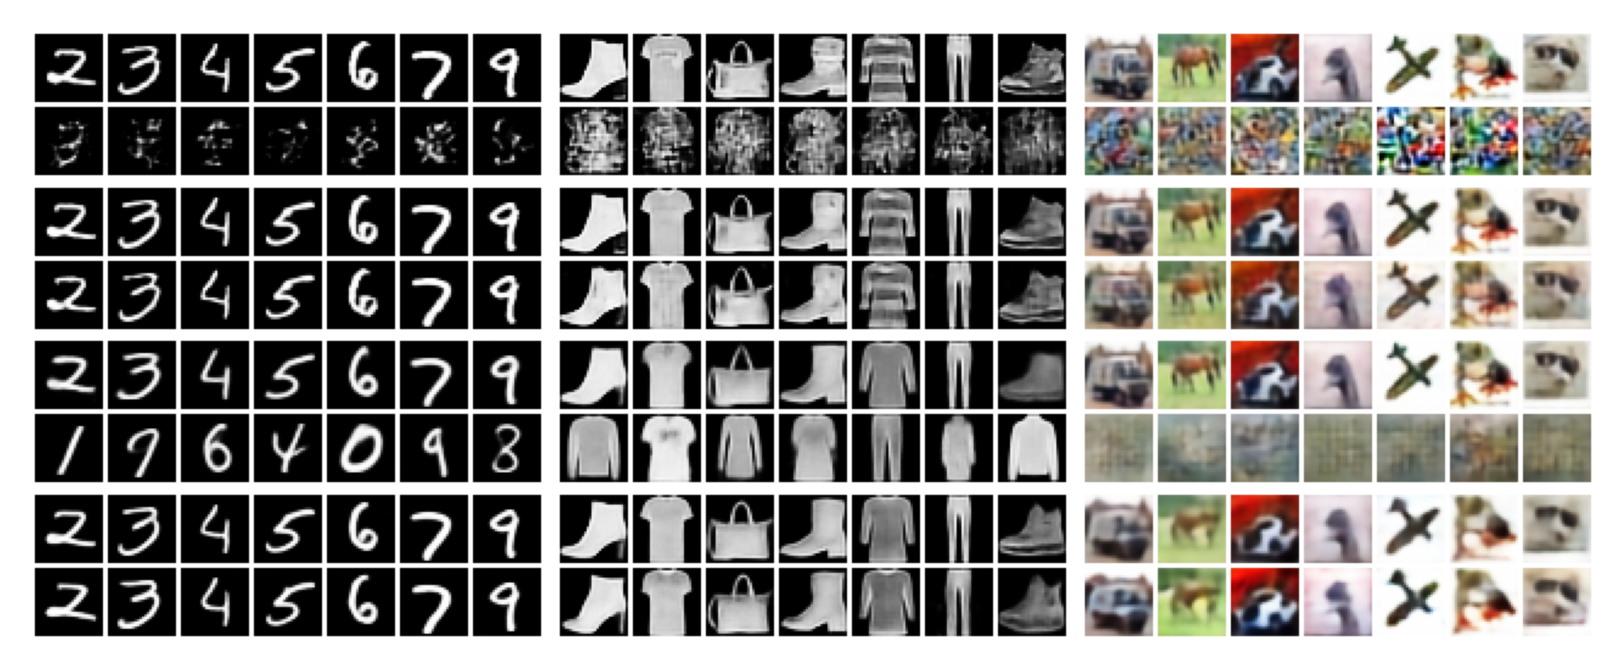

In [14]:
from pytorch_lightning import seed_everything
seed_everything(2)
A_idx = 0
B_idx = 5


import matplotlib.gridspec as gridspec

N_ROWS = 4
N_COLS = 3
RATIO = 0.3

plt.rcParams.update(bundles.icml2022())
plt.rcParams.update(figsizes.icml2022_full(ncols=N_COLS, nrows=N_ROWS, height_to_width_ratio=RATIO))


fig, [
    [ae_mnist_ax, ae_fmnist_ax, ae_cifar10_ax],
    [relae_mnist_ax, relae_fmnist_ax, relae_cifar10_ax],
    [vae_mnist_ax, vae_fmnist_ax, vae_cifar10_ax],
    [relvae_mnist_ax, relvae_fmnist_ax, relvae_cifar10_ax],
] = plt.subplots(
    N_ROWS,
    N_COLS,
    dpi=300,
    sharey=True,
    sharex=True,
    # constrained_layout=True
)
fig.subplots_adjust(hspace=0.02, wspace=0.01)

# fig.tight_layout()
# fig.subplots_adjust(hspace=0, wspace=0)
# fig.subplots_adjust(hspace = .001)


plot_stitching(
    ae_mnist_ax,
    checkpoints["mnist"]["ae"][A_idx],
    checkpoints["mnist"]["ae"][B_idx],
    batch_mnist["image"],
    padding=2,
    resize=resize,
)
plot_stitching(
    ae_fmnist_ax,
    checkpoints["fmnist"]["ae"][A_idx],
    checkpoints["fmnist"]["ae"][B_idx],
    batch_fmnist["image"],
    padding=2,
    resize=resize,
)
plot_stitching(
    ae_cifar10_ax,
    checkpoints["cifar10"]["ae"][A_idx],
    checkpoints["cifar10"]["ae"][B_idx],
    batch_cifar10["image"],
    padding=2,
    resize=resize,
)

plot_stitching(
    vae_mnist_ax,
    checkpoints["mnist"]["vae_nocal"][0],
    checkpoints["mnist"]["vae_nocal"][1],
    batch_mnist["image"],
    padding=2,
    resize=resize,
)
plot_stitching(
    vae_fmnist_ax,
    checkpoints["fmnist"]["vae_nocal"][1],
    checkpoints["fmnist"]["vae_nocal"][0],
    batch_fmnist["image"],
    padding=2,
    resize=resize,
)
plot_stitching(
    vae_cifar10_ax,
    checkpoints["cifar10"]["vae"][A_idx],
    checkpoints["cifar10"]["vae"][B_idx],
    batch_cifar10["image"],
    padding=2,
    resize=resize,
)

plot_stitching(
    relae_mnist_ax,
    checkpoints["mnist"]["rel_ae"][A_idx],
    checkpoints["mnist"]["rel_ae"][B_idx],
    batch_mnist["image"],
    padding=2,
    resize=resize,
)
plot_stitching(
    relae_fmnist_ax,
    checkpoints["fmnist"]["rel_ae"][A_idx],
    checkpoints["fmnist"]["rel_ae"][B_idx],
    batch_fmnist["image"],
    padding=2,
    resize=resize,
)
plot_stitching(
    relae_cifar10_ax,
    checkpoints["cifar10"]["rel_ae"][A_idx],
    checkpoints["cifar10"]["rel_ae"][B_idx],
    batch_cifar10["image"],
    padding=2,
    resize=resize,
)

plot_stitching(
    relvae_mnist_ax,
    checkpoints["mnist"]["rel_vae"][A_idx],
    checkpoints["mnist"]["rel_vae"][B_idx],
    batch_mnist["image"],
    padding=2,
    resize=resize,
)
plot_stitching(
    relvae_fmnist_ax,
    checkpoints["fmnist"]["rel_vae"][A_idx],
    checkpoints["fmnist"]["rel_vae"][B_idx],
    batch_fmnist["image"],
    padding=2,
    resize=resize,
)
plot_stitching(
    relvae_cifar10_ax,
    checkpoints["cifar10"]["rel_vae"][A_idx],
    checkpoints["cifar10"]["rel_vae"][B_idx],
    batch_cifar10["image"],
    padding=2,
    resize=resize,
)


In [15]:
fig.savefig("stitching.svg", bbox_inches="tight", pad_inches=0)
!rsvg-convert -f pdf -o stitching.pdf stitching.svg
!rm stitching.svg